## Load & Prepare Data

In [1]:
import pandas as pd
import numpy as np

%pip install scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import ks_2samp

# Load dataset
df = pd.read_csv("../data/ai4i/ai4i2020.csv")

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

df.head()



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,udi,product_id,type,air_temperature_[k],process_temperature_[k],rotational_speed_[rpm],torque_[nm],tool_wear_[min],machine_failure,twf,hdf,pwf,osf,rnf
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## Define Target & Time Proxy

In [2]:
target = "machine_failure"

# Keep only numeric features
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
features = [c for c in numeric_cols if c != target]

df = df.reset_index().rename(columns={"index": "time_index"})

print(f"Features: {features}")
print(f"Number of features: {len(features)}")

Features: ['udi', 'air_temperature_[k]', 'process_temperature_[k]', 'rotational_speed_[rpm]', 'torque_[nm]', 'tool_wear_[min]', 'twf', 'hdf', 'pwf', 'osf', 'rnf']
Number of features: 11


## Time-Based Split

In [3]:
split_point = int(len(df) * 0.6)

train_df = df.iloc[:split_point]
test_df  = df.iloc[split_point:]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]


## Baseline Model (NO Drift Handling)

In [4]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.99925
F1 Score: 0.9818181818181818
ROC AUC: 0.9771997665256094


## Feature Drift Detection (REAL DATA)

In [5]:
drift_results = []

for col in features:
    try:
        # Skip if column has NaN values or constant values
        if train_df[col].isna().any() or test_df[col].isna().any():
            continue
        if train_df[col].std() == 0 or test_df[col].std() == 0:
            continue
        
        stat, p_value = ks_2samp(
            train_df[col],
            test_df[col]
        )
        drift_results.append({
            "feature": col,
            "ks_stat": stat,
            "p_value": p_value
        })
    except Exception as e:
        print(f"Skipping {col}: {e}")
        continue

if drift_results:
    drift_df = pd.DataFrame(drift_results).sort_values("ks_stat", ascending=False)
    drift_df.head(10)
else:
    print("No valid features for drift analysis")

## Drift Visualization

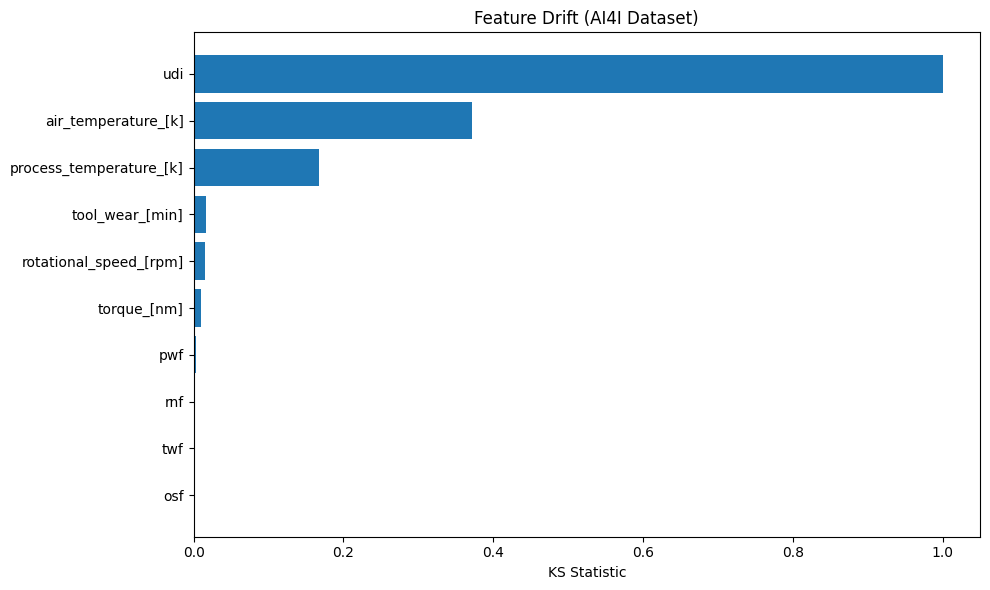

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(drift_df["feature"], drift_df["ks_stat"])
plt.xlabel("KS Statistic")
plt.title("Feature Drift (AI4I Dataset)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
